# Bulk Watershed DEM Downloader.
By - Nick Lewis.\
Advisors - Joanmarie Del Vecchio, Chuck Bailey.

# Code begins here!

#### Below is a 'code cell'.  This is a block of text that Jupyter and Python use to perform tasks.

#### To run the following code cell and all code cells below, select the cell and press
# <p style="color: aqua;">Shift+Enter.</p>

In [2]:
# Import packages to our notebook.
# We must do this to use the functions contained inside the packages.
# Some functions have 'as' in the import call.  This is for less typing, and nothing else.
# Google any package name and 'docs' in order to find more detailed explanation of any one package.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import geopandas as gpd
import xdem
import os
import rasterio as rio
from rasterio.plot import show
import glob
from concurrent.futures import ThreadPoolExecutor
import requests
import shapely
from tqdm import tqdm
import json
from shapely.geometry import shape
from rasterio.mask import mask
from rasterio.crs import CRS
import rioxarray as rxr
from shapely import wkt
from pyproj import Proj, transform
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### Below is a code cell containing our **Constant** Variables, which you may change as you see fit for your particular analyses.

#### Below are 
- Integers
- Lists (denoted by square brackets at the beginning and end, separated by commas [a, b, c, d])
- Strings (contained within quotes 'Like this!')

In [3]:
# Every time you change something within the code cell, run it once more to update the variable.

BOUNDS = [39.7299, -77.5886, 36.9909, -81.6319] # In decimal coordinate form.  Format: [N, E, S, W].  Select the smallest area possible in your analyses for maximum resoultion!  

API_KEY = '9086887f175d33aa72eda767f5b1e9cd' # Get your API key from opentopography.org.  Students get higher resolution data!

DEM_DATASET = 'USGS30m' # Options are USGS30m, USGS10m, & USGS1m.  Be warned!  As resolution goes up, available download area goes down.

PROJ_TITLE = 'wv_tot' # Create a succinct name with no spaces or leading digits to represent your project file for future exports.

PATH = os.getcwd()

#### If you can't remember what a function does, call the help() function and pass the name of the function you are wondering about inside the colons.

In [4]:
def lsht(dem_dir=f'{PATH}/{PROJ_TITLE}/wshed_dems'):
    """

    """
    path_list = glob.glob(f'{dem_dir}/*.tiff') # Create a list of all the paths to our watershed DEMs.
    
    def df_maker(path):
        dem = xdem.DEM(path) # Load in the DEM.
        tri = dem.terrain_ruggedness_index(window_size=3) # Make an SLRM (Simple Local Relief Model) of the DEM.  3 pix window size.

        # Next we are going to find the 10th percentile relief for the dem.
        t_data = tri.data # Get our data.
        t_data = np.asarray(t_data)
        t_valid_mask = ~np.isnan(t_data)
        t_valid = t_data[t_valid_mask] # Create a mask that is false if it is nan.  Extract valid values.
        perc_10th = np.percentile(t_valid, 10) # From valid values, get 10th percentile.
        t_bool_mask = np.where(t_valid_mask & (t_data < perc_10th), True, False) # True if data is valid and below 10th percentile. False otherwise.

        # We now repeat the process to find the 90th percentile elevation.
        e_data = dem.data
        e_data = np.asarray(e_data)
        e_valid_mask = ~np.isnan(e_data)
        e_valid = e_data[e_valid_mask] # Create a mask that is false if it is nan.  Extract valid values.
        perc_90th = np.percentile(e_valid, 90) # From valid values, get 10th percentile.
        e_bool_mask = np.where(e_valid_mask &  (e_data > perc_90th), True, False)

        # Get the name for our export csv.
        name = path.split(sep='/')
        name = name[-1][:-5]

        # Create our df.
        # First get our coordinate values.
        nrows, ncols = tri.data.shape
        rows, cols = np.indices((nrows, ncols))
        xs, ys = tri.transform * (cols, rows)

        names = [name] * len(xs.flatten())

        data = {'lon':xs.flatten(), 'lat':ys.flatten(), 'b_10_s':t_bool_mask.flatten(), 'abv_90_t':e_bool_mask.flatten(), 'Wshed_name':names}
        df = pd.DataFrame(data=data)
        return df
        
    
    with ThreadPoolExecutor() as executor:
        results_iter = executor.map(df_maker, path_list)
        results = list(results_iter)

    return results

lsht_list = lsht()

In [5]:
def kp_retriever(lsht_list, chi_plot = False):
    kp_list = []
    if chi_plot == True:
        try:
            os.mkdir(f'{PATH}/{PROJ_TITLE}/chi_plots')
            print(f'Directory "{PATH}/{PROJ_TITLE}/chi_plots" created successfully.')
        except FileExistsError:
            print('Directory exists')
        except Exception as e:
            print(f'An error occurred: {e}')
    for df in lsht_list:
        wshed_name = df.iloc[0].Wshed_name
        ksn_df = pd.read_csv(f'{PATH}/{PROJ_TITLE}/ksn_csvs/{wshed_name}_reproj_knickpoints.csv')
        in_proj = Proj(init='epsg:2283')  # Replace with your specific easting/northing EPSG code
        out_proj = Proj(init='epsg:4269')   # WGS84 for latitude/longitude
        easting = ksn_df.x.values  # Example easting
        northing = ksn_df.y.values # Example northing
        longitude, latitude = transform(in_proj, out_proj, easting, northing)
        ksn_df['longitude'] = longitude
        ksn_df['latitude'] = latitude
        ksn_df['wshed'] = [wshed_name]*len(ksn_df)
        if chi_plot == True:
            fig, ax = plt.subplots(figsize=(10,10))
            sns.scatterplot(data=ksn_df, x='flow_distance', y='chi', c='k', alpha=0.5, s=10, ax=ax)
            sns.scatterplot(data=ksn_df, x='flow_distance', y='chi', hue=np.abs(np.asarray(ksn_df['delta_ksn'])))
            plt.legend(title = r'Knickpoint $\Delta k_{sn}$')
            wshed_name_sp = wshed_name.replace('_', ' ')
            plt.title(f'{wshed_name_sp} $\chi$ plot')
            plt.savefig(f'{PATH}/{PROJ_TITLE}/chi_plots/{wshed_name}_chiplot.png')
            plt.close()
        kp_list.append(ksn_df)
    return kp_list
kp_list = kp_retriever(lsht_list, chi_plot=True)

Directory "/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/jupyter_proto/wv_tot/chi_plots" created successfully.


In [14]:
display(lsht_list[0], kp_list[0])

lon        lat  b_10_s  abv_90_t  \
0       -78.831666  38.516111   False     False   
1       -78.831388  38.516111   False     False   
2       -78.831110  38.516111   False     False   
3       -78.830833  38.516111   False     False   
4       -78.830555  38.516111   False     False   
...            ...        ...     ...       ...   
1506216 -78.441666  38.219444   False     False   
1506217 -78.441388  38.219444   False     False   
1506218 -78.441110  38.219444   False     False   
1506219 -78.440833  38.219444   False     False   
1506220 -78.440555  38.219444   False     False   

                                      Wshed_name  
0        Naked_Creek-South_Fork_Shenandoah_River  
1        Naked_Creek-South_Fork_Shenandoah_River  
2        Naked_Creek-South_Fork_Shenandoah_River  
3        Naked_Creek-South_Fork_Shenandoah_River  
4        Naked_Creek-South_Fork_Shenandoah_River  
...                                          ...  
1506216  Naked_Creek-South_Fork_Shenandoah_River  
1506217  Naked_Creek-South_Fork_Shenandoah_River  
1506218  Naked_Creek-South_Fork_Shenandoah_River  
1506219  Naked_Creek-South_Fork_Shenandoah_River  
1506220  Naked_Creek-South_Fork_Shenandoah_River  

[1506221 rows x 5 columns]

Unnamed: 0  basin_key   col   nodeID   row  sign  source_key        chi  \
0             0          0   623     1359     2     1           0   0.000000   
1             1          0  1159    41265    33     1         120  12.938111   
2             2          0  1146    46332    37    -1         120  11.962489   
3             3          0  1154    47610    38    -1         118  12.196698   
4             4          0  1243    71829    57    -1         116  14.238316   
..          ...        ...   ...      ...   ...   ...         ...        ...   
470         470          0   154  1319064  1038     1           0  11.772914   
471         471          0   155  1321613  1040     1           0  11.813132   
472         472          0   156  1322888  1041     1           0  11.837062   
473         473          0   162  1324168  1042     1           0  11.945988   
474         474          0   497  1325777  1043     1          45  13.173102   

      delta_ksn  delta_zseg  drainage_area  elevation  flow_distance  \
0      1.872887    0.000000   6.931692e+09  242.73302          0.000   
1      0.324205    0.000000   8.804229e+06  672.42360      93928.900   
2     -0.929872    0.000000   2.178542e+07  651.68940      92461.260   
3     -9.862106    0.000000   2.120313e+07  668.25710      92923.195   
4   -102.263650    0.000000   1.240666e+07  910.13385      94689.164   
..          ...         ...            ...        ...            ...   
470    0.000000    0.555725   1.926760e+08  379.62357     165726.780   
471    0.000000    0.545685   1.817444e+08  381.17750     165939.500   
472    0.000000    0.571533   1.816202e+08  381.18372     166064.110   
473    0.000000    0.556122   1.792988e+08  384.15598     166629.270   
474    0.000000    5.203491   2.876514e+07  577.39526     147283.230   

              x          y  longitude   latitude  \
0    11442569.0  6870957.0 -78.641017  38.515892   
1    11489798.0  6868225.5 -78.475952  38.508474   
2    11488652.0  6867873.0 -78.479957  38.507507   
3    11489357.0  6867785.0 -78.477493  38.507265   
4    11497199.0  6866110.5 -78.450092  38.502658   
..          ...        ...        ...        ...   
470  11401244.0  6779672.0 -78.784461  38.264964   
471  11401332.0  6779496.0 -78.784152  38.264481   
472  11401421.0  6779407.5 -78.783842  38.264239   
473  11401949.0  6779319.5 -78.782002  38.264002   
474  11431467.0  6779231.5 -78.679193  38.263963   

                                       wshed  
0    Naked_Creek-South_Fork_Shenandoah_River  
1    Naked_Creek-South_Fork_Shenandoah_River  
2    Naked_Creek-South_Fork_Shenandoah_River  
3    Naked_Creek-South_Fork_Shenandoah_River  
4    Naked_Creek-South_Fork_Shenandoah_River  
..                                       ...  
470  Naked_Creek-South_Fork_Shenandoah_River  
471  Naked_Creek-South_Fork_Shenandoah_River  
472  Naked_Creek-South_Fork_Shenandoah_River  
473  Naked_Creek-South_Fork_Shenandoah_River  
474  Naked_Creek-South_Fork_Shenandoah_River  

[475 rows x 18 columns]

In [ ]:
def mapper(df, ksn_df):
    try:
        os.mkdir(f'{PATH}/{PROJ_TITLE}/kps_mapped')
    except FileExistsError:
        print('Directory exists')
    except Exception as e:
        print(f'An Error occured : {e}')
    ls = df['b_10_s'] == True
    ht = df['abv_90_t'] == True
    df_masked = df[ls & ht]
    xs = df_masked.lon
    ys = df_masked.lat
    wshed_name = df_masked.iloc[0].Wshed_name
    fig, ax = plt.subplots(figsize=(20,20), dpi=200)
    with rio.open(f'{PATH}/{PROJ_TITLE}/wshed_dems/{wshed_name}.tiff') as src:
        show(src, cmap='terrain', ax=ax)
    ax.scatter(xs, ys, c='r', s=5)
    wshed_name_sp = wshed_name.replace('_', ' ')
    title = f'{wshed_name_sp} LSHT plotted.'
    plt.title(label = title)
    high_kps = gpd.sjoin_nearest(gpd.GeoDataFrame(ksn_df, geometry=gpd.points_from_xy(ksn_df['longitude'], ksn_df['latitude'], crs = CRS.from_epsg(2283))), 
                                 gpd.GeoDataFrame(df_masked, geometry=gpd.points_from_xy(df_masked['lon'], df_masked['lat']), crs=CRS.from_epsg(2283)), 
                                 distance_col = 'dist_from_lsht')
    
    sns.scatterplot(data=high_kps[high_kps.dist_from_lsht <= 25], x='longitude', y='latitude', hue=np.abs(np.asarray(ksn_df['delta_ksn'])), ax=ax, palette='Greys', marker='s')
    ax.legend(title= r'Knickpoint $\Delta k_{sn}$)')
    plt.savefig(f'{PATH}/{PROJ_TITLE}/kps_mapped/{wshed_name}_mapped.png')
    plt.close()

Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists


KeyboardInterrupt: 

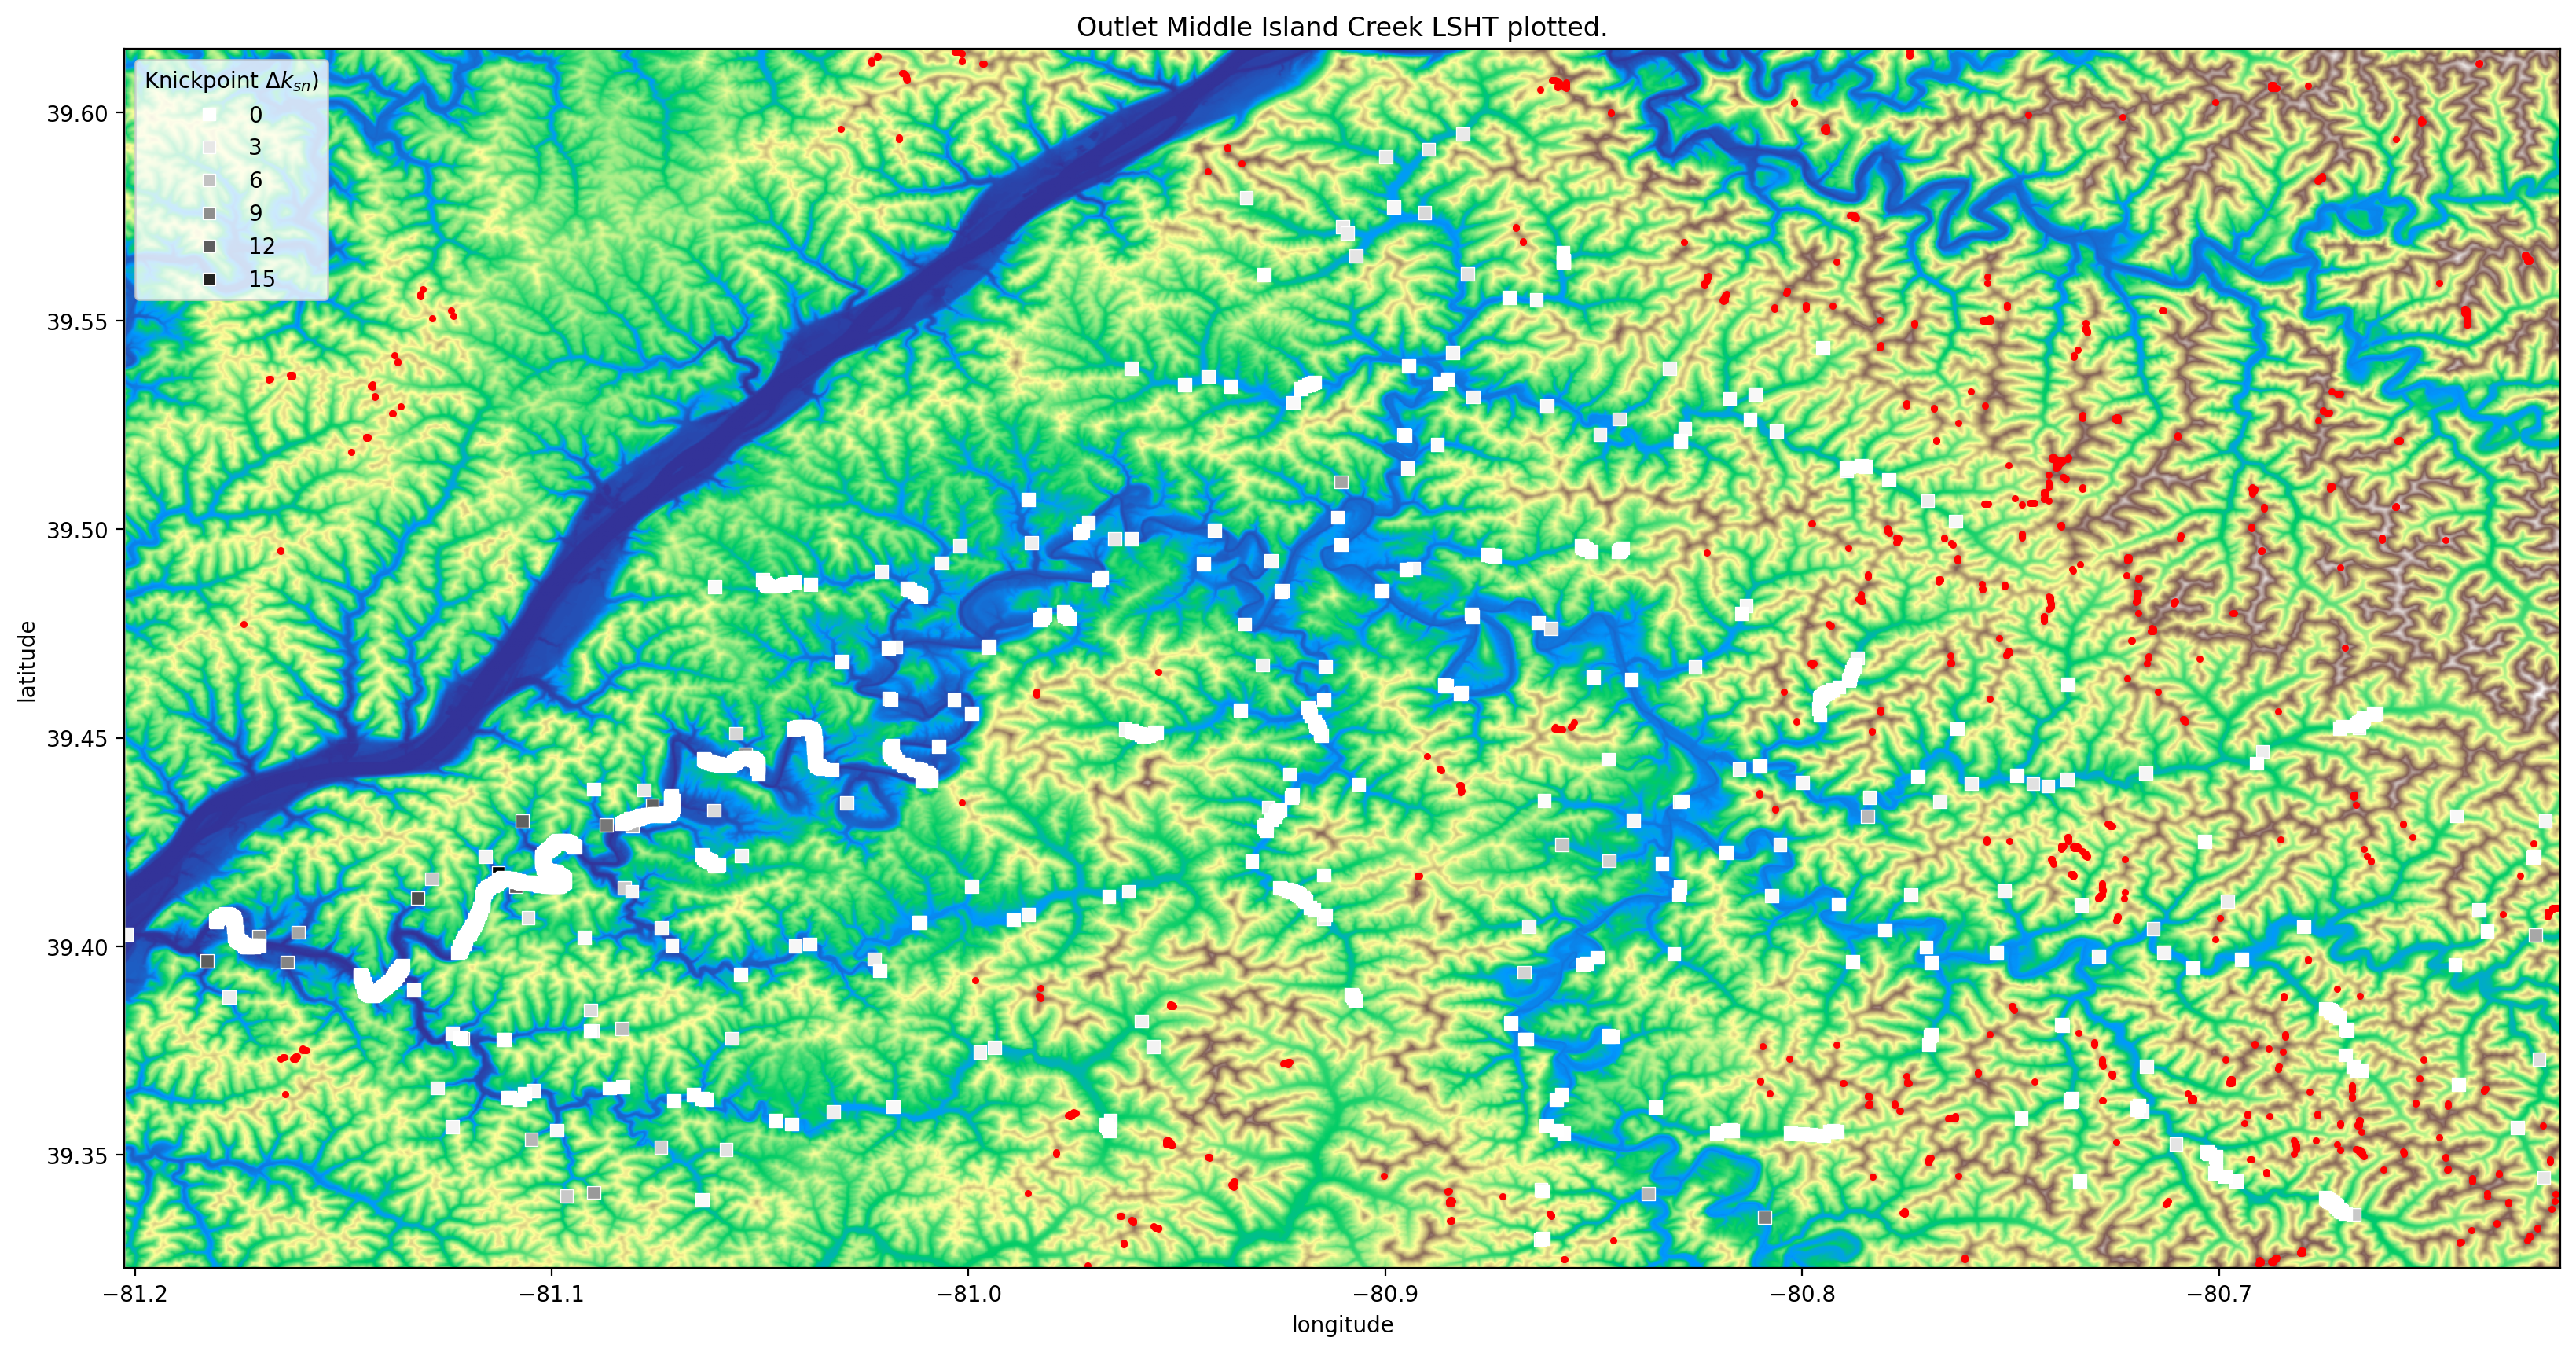

In [20]:
for lsht, kp in zip(lsht_list, kp_list):
    mapper(lsht, kp)